In [26]:
import pandas as pd
import networkx as nx
pd.options.display.max_columns = None
import aethos as at

In [47]:
blue_df = pd.read_json('/mnt/d/sysmon.json', lines=True, chunksize=100000)
red_df = pd.read_json('/mnt/d/empire_apt3_2019-05-14223117.json', lines=True)

## Blue or Non Malicious Data

*If you already have a combined blue and red dataset, skip to Graph section*

In [48]:
for ind,df in enumerate(blue_df):
    if ind == 10:
        blue_df = df
        break

In [50]:
blue_df = pd.io.json.json_normalize(blue_df['_source'])

In [51]:
blue_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 168 columns):
@timestamp                                      object
message                                         object
agent.id                                        object
agent.version                                   object
agent.type                                      object
agent.ephemeral_id                              object
agent.hostname                                  object
host.name                                       object
host.id                                         object
host.hostname                                   object
host.architecture                               object
host.os.kernel                                  object
host.os.build                                   object
host.os.platform                                object
host.os.version                                 object
host.os.family                                  object
host.os.n

Columns of importance:

- process.executable
- process.name
- process.parent.name
- winlog.event_data.ParentCommandLine
- winlog.event_data.ParentImage
- winlog.event_data.CommandLine
- winlog.event_data.User
- winlog.user.domain

In [52]:
blue_df['malicious'] = 0

In [53]:
blue_feature_cols = [
    'process.executable',
    'process.name',
    'process.parent.name',
    'winlog.event_data.ParentCommandLine',
    'winlog.event_data.ParentImage',
    'winlog.event_data.CommandLine',
    'winlog.event_data.User',
    'malicious'
]

In [54]:
blue_df.head()

,@timestamp,message,agent.id,agent.version,agent.type,agent.ephemeral_id,agent.hostname,host.name,host.id,host.hostname,host.architecture,host.os.kernel,host.os.build,host.os.platform,host.os.version,host.os.family,host.os.name,log.level,user.domain,user.name,event.action,event.created,event.module,event.category,event.type,event.kind,event.code,process.name,process.entity_id,process.pid,process.executable,process.args,process.working_directory,process.parent.entity_id,process.parent.pid,process.parent.executable,process.parent.args,process.parent.name,hash.sha1,hash.md5,hash.sha256,hash.imphash,ecs.version,winlog.opcode,winlog.provider_guid,winlog.event_id,winlog.api,winlog.version,winlog.process.pid,winlog.process.thread.id,winlog.user.type,winlog.user.identifier,winlog.user.name,winlog.user.domain,winlog.event_data.IntegrityLevel,winlog.event_data.Company,winlog.event_data.OriginalFileName,winlog.event_data.FileVersion,winlog.event_data.LogonId,winlog.event_data.Description,winlog.event_data.TerminalSessionId,winlog.event_data.LogonGuid,winlog.event_data.Product,winlog.provider_name,winlog.channel,winlog.record_id,winlog.task,winlog.computer_name,source.ip,source.domain,source.port,destination.ip,destination.domain,destination.port,network.transport,network.direction,network.type,network.community_id,network.protocol,winlog.event_data.DestinationHostname,winlog.event_data.User,winlog.event_data.DestinationPort,winlog.event_data.Protocol,winlog.event_data.SourceIsIpv6,winlog.event_data.UtcTime,winlog.event_data.ProcessGuid,winlog.event_data.Initiated,winlog.event_data.DestinationIp,winlog.event_data.Image,winlog.event_data.ProcessId,winlog.event_data.SourceIp,winlog.event_data.SourceHostname,winlog.event_data.DestinationIsIpv6,winlog.event_data.SourcePort,winlog.event_data.ParentImage,winlog.event_data.ParentCommandLine,winlog.event_data.ParentProcessId,winlog.event_data.Hashes,winlog.event_data.CommandLine,winlog.event_data.ParentProcessGuid,winlog.event_data.CurrentDirectory,winlog.event_data.DestinationPortName,tags,error.message,winlog.event_data.SourcePortName,event.outcome,user.id,winlog.logon.id,winlog.logon.type,winlog.keywords,winlog.activity_id,winlog.event_data.RestrictedAdminMode,winlog.event_data.AuthenticationPackageName,winlog.event_data.TransmittedServices,winlog.event_data.ImpersonationLevel,winlog.event_data.IpAddress,winlog.event_data.LogonProcessName,winlog.event_data.LogonType,winlog.event_data.SubjectDomainName,winlog.event_data.TargetLogonId,winlog.event_data.LmPackageName,winlog.event_data.SubjectUserSid,winlog.event_data.SubjectUserName,winlog.event_data.SubjectLogonId,winlog.event_data.ElevatedToken,winlog.event_data.IpPort,winlog.event_data.VirtualAccount,winlog.event_data.TargetOutboundUserName,winlog.event_data.TargetDomainName,winlog.event_data.KeyLength,winlog.event_data.TargetLinkedLogonId,winlog.event_data.TargetUserName,winlog.event_data.TargetOutboundDomainName,winlog.event_data.TargetUserSid,winlog.event_data.PrivilegeList,winlog.event_data.param2,winlog.event_data.param3,winlog.event_data.param4,winlog.event_data.param5,winlog.event_data.param1,winlog.event_data.CreationUtcTime,winlog.event_data.PreviousCreationUtcTime,winlog.event_data.TargetFilename,file.path,winlog.event_data.CallerProcessName,winlog.event_data.CallerProcessId,winlog.event_data.TargetSid,winlog.event_data.ProcessCreationTime,winlog.event_data.ReadOperation,winlog.event_data.ClientProcessId,winlog.event_data.Type,winlog.event_data.ReturnCode,winlog.event_data.TargetName,winlog.event_data.CountOfCredentialsReturned,winlog.event_data.SchemaFriendlyName,winlog.event_data.Schema,winlog.event_data.Flags,winlog.event_data.Resource,winlog.event_data.Identity,winlog.event_data.QueryName,winlog.event_data.AddressLength,winlog.event_data.Address,winlog.event_data.param7,winlog.event_data.param11,winlog.event_data.param9,winlog.event_data.param10,winlog.event_data.param6,winlog.event_data.param8,malicious
0,2019-10-19T02:49:49.978

In [55]:
cleaned_blue_df = blue_df[~blue_df['process.name'].isnull()] \
    .loc[:, blue_feature_cols]

In [56]:
print(cleaned_blue_df.shape)
cleaned_blue_df.head()

(49809, 8)


,process.executable,process.name,process.parent.name,winlog.event_data.ParentCommandLine,winlog.event_data.ParentImage,winlog.event_data.CommandLine,winlog.event_data.User,malicious
0,C:\Windows\System32\cmd.exe,cmd.exe,kited.exe,NaN,NaN,NaN,NaN,0
1,C:\Windows\System32\conhost.exe,conhost.exe,cmd.exe,NaN,NaN,NaN,NaN,0
2,C:\Program Files\Microsoft VS Code\Code.exe,Code.exe,cmd.exe,NaN,NaN,NaN,NaN,0
3,C:\Users\ashto\AppData\Local\Packages\Canonica...,node,NaN,NaN,NaN,NaN,NaN,0
4,C:\Users\ashto\AppData\Local\Packages\Canonica...,python3,NaN,NaN,NaN,NaN,NaN,0


In [57]:
df_helper = at.Data(cleaned_blue_df, split=False)

In [58]:
df_helper.data_report()

In [38]:
cleaned_blue_df['process.name'].unique()

array(['Plex Transcoder.exe', 'Plex Media Server.exe', 'node',
       'kited.exe', '<unknown process>', 'Plex DLNA Server.exe',
       'conhost.exe', 'python3', 'nvcontainer.exe', 'svchost.exe',
       'Code.exe', 'NzbDrone.Console.exe', 'SABnzbd.exe', 'firefox.exe',
       'Steam.exe', 'grafana-server.exe', 'System', 'KiteService.exe',
       'backgroundTaskHost.exe', 'RuntimeBroker.exe', 'services.exe',
       'Plex Media Scanner.exe', 'smartscreen.exe', 'cmd.exe',
       'SearchProtocolHost.exe', 'SearchFilterHost.exe', 'OneDrive.exe',
       'nzbdrone.console.exe', 'CouchPotato.exe', 'PlexScriptHost.exe',
       'audiodg.exe', 'LogiOptionsMgr.exe', 'steamwebhelper.exe',
       'BackgroundDownload.exe', 'officebackgroundtaskhandler.exe',
       'taskhostw.exe', 'node.exe', 'LogonUI.exe', 'dllhost.exe',
       'OfficeClickToRun.exe', 'OfficeC2RClient.exe',
       'Microsoft.Photos.exe', 'GoogleUpdate.exe', 'VyprVPNService.exe',
       'WmiPrvSE.exe', 'steam.exe', 'StartMenuExperience

In [46]:
cleaned_blue_df[cleaned_blue_df['process.parent.name'].isnull()]['process.name'].unique()

array(['Plex Transcoder.exe', 'Plex Media Server.exe', 'node',
       'kited.exe', '<unknown process>', 'Plex DLNA Server.exe',
       'python3', 'nvcontainer.exe', 'svchost.exe', 'Code.exe',
       'NzbDrone.Console.exe', 'SABnzbd.exe', 'firefox.exe', 'Steam.exe',
       'grafana-server.exe', 'System', 'KiteService.exe', 'services.exe',
       'backgroundTaskHost.exe', 'smartscreen.exe', 'OneDrive.exe',
       'nzbdrone.console.exe', 'CouchPotato.exe', 'PlexScriptHost.exe',
       'LogiOptionsMgr.exe', 'steamwebhelper.exe',
       'BackgroundDownload.exe', 'Plex Media Scanner.exe', 'node.exe',
       'LogonUI.exe', 'OfficeClickToRun.exe', 'OfficeC2RClient.exe',
       'Microsoft.Photos.exe', 'VyprVPNService.exe', 'steam.exe',
       'StartMenuExperienceHost.exe', 'ssh', '0.dat',
       'NVIDIA Web Helper.exe', 'msiexec.exe', 'Integrator.exe',
       'addinutil.exe', 'SDXHelper.exe', 'NisSrv.exe', 'SearchUI.exe',
       'OLicenseHeartbeat.exe', 'SpeechModelDownload.exe'], dtype=object)

In [60]:
cleaned_blue_df[cleaned_blue_df['process.parent.name'].isnull()]['process.name']

3                         node
4                      python3
5                    kited.exe
6                    kited.exe
13                   kited.exe
                 ...          
99993     Plex DLNA Server.exe
99994    Plex Media Server.exe
99995     Plex DLNA Server.exe
99996     Plex DLNA Server.exe
99999                     node
Name: process.name, Length: 49381, dtype: object

In [61]:
cleaned_blue_df[cleaned_blue_df['process.parent.name'].isnull()]['process.parent.name'] = cleaned_blue_df[cleaned_blue_df['process.parent.name'].isnull()]['process.name']

## Red or Malicious Data

In [10]:
red_df

,@timestamp,@metadata,log_name,message,type,record_number,computer_name,version,event_data,source_name,thread_id,user,provider_guid,host,beat,opcode,event_id,task,process_id,level,keywords,activity_id,user_data
0,2019-05-14T22:31:14.252Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Microsoft-Windows-Sysmon/Operational,Process accessed:\nRuleName: \nUtcTime: 2019-0...,wineventlog,1446958,HR001.shire.com,3.0,"{'TargetProcessId': '3476', 'SourceThreadId': ...",Microsoft-Windows-Sysmon,3144.0,"{'identifier': 'S-1-5-18', 'name': 'SYSTEM', '...",{5770385f-c22a-43e0-bf4c-06f5698ffbd9},{'name': 'WECserver'},"{'hostname': 'WECserver', 'version': '6.7.0', ...",Info,10,Process accessed (rule: ProcessAccess),2440.0,Information,NaN,NaN,NaN
1,2019-05-14T22:31:14.253Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Microsoft-Windows-Sysmon/Operational,Process accessed:\nRuleName: \nUtcTime: 2019-0...,wineventlog,1446959,HR001.shire.com,3.0,"{'TargetProcessId': '3476', 'TargetImage': 'C:...",Microsoft-Windows-Sysmon,3144.0,"{'name': 'SYSTEM', 'domain': 'NT AUTHORITY', '...",{5770385f-c22a-43e0-bf4c-06f5698ffbd9},{'name': 'WECserver'},"{'name': 'WECserver', 'hostname': 'WECserver',...",Info,10,Process accessed (rule: ProcessAccess),2440.0,Information,NaN,NaN,NaN
2,2019-05-14T22:31:14.727Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Microsoft-Windows-Sysmon/Operational,Network connection detected:\nRuleName: \nUtcT...,wineventlog,5025649,HFDC01.shire.com,5.0,"{'SourceHostname': 'HFDC01.shire.com', 'Source...",Microsoft-Windows-Sysmon,2660.0,"{'identifier': 'S-1-5-18', 'name': 'SYSTEM', '...",{5770385F-C22A-43E0-BF4C-06F5698FFBD9},{'name': 'WECserver'},"{'name': 'WECserver', 'hostname': 'WECserver',...",Info,3,Network connection detected (rule: NetworkConn...,1368.0,Information,NaN,NaN,NaN
3,2019-05-14T22:31:15.268Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Microsoft-Windows-Sysmon/Operational,Process accessed:\nRuleName: \nUtcTime: 2019-0...,wineventlog,1446960,HR001.shire.com,3.0,"{'TargetProcessId': '3476', 'CallTrace': 'C:\W...",Microsoft-Windows-Sysmon,3144.0,"{'domain': 'NT AUTHORITY', 'type': 'User', 'id...",{5770385f-c22a-43e0-bf4c-06f5698ffbd9},{'name': 'WECserver'},"{'name': 'WECserver', 'hostname': 'WECserver',...",Info,10,Process accessed (rule: ProcessAccess),2440.0,Information,NaN,NaN,NaN
4,2019-05-14T22:31:15.219Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Security,An attempt was made to duplicate a handle to a...,wineventlog,109345,HR001.shire.com,NaN,"{'TargetProcessId': '0x4', 'SubjectUserSid': '...",Microsoft-Windows-Security-Auditing,6364.0,NaN,{54849625-5478-4994-a5ba-3e3b0328c30d},{'name': 'WECserver'},"{'name': 'WECserver', 'hostname': 'WECserver',...",Info,4690,Handle Manipulation,4.0,Information,[Audit Success],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121654,2019-05-14T23:47:44.206Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Microsoft-Windows-PowerShell/Operational,"CommandInvocation(Get-Random): ""Get-Random""\nP...",wineventlog,19200,HR001.shire.com,1.0,"{'Payload': 'CommandInvocation(Get-Random): ""G...",Microsoft-Windows-PowerShell,3660.0,{'identifier': 'S-1-5-21-2511471446-1103646877...,{a0c1853b-5c40-4b15-8766-3cf1c58f985a},{'name': 'WECserver'},"{'name': 'WECserver', 'hostname': 'WECserver',...",To be used when operation is just executing a ...,4103,Executing Pipeline,7048.0,Information,NaN,{c93a7728-017f-0000-413f-7ec97f01d501},NaN
121655,2019-05-14T23:47:43.692Z,"{'beat': 'winlogbeat', 'type': 'doc', 'version...",Security,The Windows Filtering Platform has permitted a...,wineventlog,118190,HR001.shire.com,1.0,"{'Protocol': '6', 'LayerRTID': '48', 'Directio...",Microsoft-Windows-Security-Auditing,1092.0,NaN,{54849625-5478-4994-a5ba-3e3b0328c30d},{'name': 'WECserver'},"{'hostname': 'WECserver', 'version': '6.7.0', ...",Info,5156,Filtering Platform Connection,4.0,Information,[Audit Success],NaN,NaN
121656,2

In [14]:
event_df = pd.io.json.json_normalize(red_df['event_data'].dropna())
event_df

,TargetProcessId,SourceThreadId,SourceImage,GrantedAccess,CallTrace,UtcTime,SourceProcessGUID,TargetProcessGUID,SourceProcessId,TargetImage,SourceHostname,SourceIsIpv6,Protocol,ProcessGuid,SourceIp,SourcePortName,DestinationIp,DestinationPort,ProcessId,DestinationIsIpv6,SourcePort,Image,User,Initiated,DestinationHostname,SubjectUserSid,SubjectUserName,SubjectDomainName,SubjectLogonId,SourceHandleId,TargetHandleId,HandleId,ProcessName,ObjectServer,TransactionId,RestrictedSidCount,AccessReason,ResourceAttributes,AccessMask,PrivilegeList,ObjectType,ObjectName,AccessList,TargetUserSid,TargetDomainName,TargetUserName,TargetLogonId,EnabledPrivilegeList,DisabledPrivilegeList,PipeName,Company,Signed,Hashes,SignatureStatus,Product,ImageLoaded,FileVersion,Description,Signature,TargetObject,EventType,LayerName,LayerRTID,Application,SourceAddress,FilterRTID,ProcessID,Direction,DestAddress,DestPort,RemoteUserID,RemoteMachineID,ImpersonationLevel,TargetLinkedLogonId,LogonProcessName,TransmittedServices,TargetOutboundDomainName,KeyLength,RestrictedAdminMode,LogonType,LmPackageName,VirtualAccount,IpPort,IpAddress,TargetOutboundUserName,ElevatedToken,AuthenticationPackageName,LogonGuid,EventCountTotal,GroupMembership,EventIdx,DestinationPortName,Details,ServiceName,Status,PreAuthType,TargetSid,TicketOptions,ServiceSid,TicketEncryptionType,Device,Service,TargetInfo,TargetLogonGuid,TargetServerName,WorkstationName,SessionId,ParentProcessName,TokenElevationType,MandatoryLabel,CommandLine,NewProcessId,NewProcessName,TerminalSessionId,CurrentDirectory,ParentProcessId,ParentCommandLine,IntegrityLevel,ParentProcessGuid,LogonId,ParentImage,ShareLocalPath,ShareName,RelativeTargetName,NewSd,OldSd,TargetFilename,CreationUtcTime,ProfileChanged,RuleId,RuleName,Flags,SecurityOptions,Action,ModifyingApplication,LocalAddresses,LocalOnlyMapped,RuleStatus,RemoteAddresses,LooseSourceMapped,Active,EmbeddedContext,ModifyingUser,Profiles,SchemaVersion,EdgeTraversal,Origin,PreviousCreationUtcTime,Hash,param1,param2,param3,ScriptBlockId,MessageNumber,MessageTotal,ScriptBlockText,RunspaceId,Payload,ContextInfo,TaskName,TaskContentNew,Binary,SupportInfo1,SupportInfo2,ProcessingMode,ProcessingTimeInMilliseconds,DCName,Properties,Client Network Address:,Client SID:,CallerProcessName,CallerProcessId,AdditionalInfo2,AdditionalInfo,OperationType,SidHistory,SamAccountName,CountOfCredentialsReturned,ReadOperation,ReturnCode,TargetName,Type,ClientProcessId,ProcessCreationTime,AccountName,ImagePath,ServiceType,StartType,ServiceFileName,ServiceStartType,ServiceAccount,param4,param5,param9,param11,param10,param6,param8,param7,Path,KeyFilePath,KeyType,Operation,ProviderName,KeyName,AlgorithmName,PackageName,Workstation,TSId,UserSid,KeysUpdated,DirtyPages,HiveNameLength,HiveName,ClassId,LocationInformation,CompatibleIds,DeviceId,DeviceDescription,VendorIds,ClassName,ExtensionId,ErrorCode,ExtensionName,ErrorDescription,SubStatus,FailureReason,ResourceManager,NewState,number
0,3476,820,C:\Windows\system32\svchost.exe,0x1000,C:\Windows\SYSTEM32\ntdll.dll+9fb54|C:\Windows...,2019-05-14 22:31:14.249,{03ba39f5-ea62-5ccb-0000-001096a70000},{03ba39f5-e681-5cda-0000-00105cc50c00},748,C:\Windows\System32\svchost.exe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [15]:
event_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121580 entries, 0 to 121579
Data columns (total 230 columns):
TargetProcessId                 object
SourceThreadId                  object
SourceImage                     object
GrantedAccess                   object
CallTrace                       object
UtcTime                         object
SourceProcessGUID               object
TargetProcessGUID               object
SourceProcessId                 object
TargetImage                     object
SourceHostname                  object
SourceIsIpv6                    object
Protocol                        object
ProcessGuid                     object
SourceIp                        object
SourcePortName                  object
DestinationIp                   object
DestinationPort                 object
ProcessId                       object
DestinationIsIpv6               object
SourcePort                      object
Image                           object
User                          

In [16]:
red_feature_cols = [
    'Image',
    'ProcessName',
    'ParentProcessName',
    'ParentCommandLine',
    'ParentImage',
    'CommandLine',
    'User',
]

In [17]:
red_df = event_df.loc[:, red_feature_cols]

## Combine the datasets

In [18]:
cols = [
    'process',
    'process_name',
    'parent_process',
    'parent_process_name',
    'parent_cmd_line',
    'cmd_line',
    'user'
]

cleaned_blue_df.columns = cols
red_df.columns = cols

In [24]:
df = pd.concat([cleaned_blue_df, red_df])
df

,process,process_name,parent_process,parent_process_name,parent_cmd_line,cmd_line,user
100,C:\Program Files (x86)\Plex\Plex Media Server\...,Plex Transcoder.exe,NaN,NaN,NaN,NaN,NaN
101,C:\Program Files (x86)\Plex\Plex Media Server\...,Plex Media Server.exe,NaN,NaN,NaN,NaN,NaN
102,C:\Program Files (x86)\Plex\Plex Media Server\...,Plex Transcoder.exe,NaN,NaN,NaN,NaN,NaN
103,C:\Program Files (x86)\Plex\Plex Media Server\...,Plex Media Server.exe,NaN,NaN,NaN,NaN,NaN
104,C:\Program Files (x86)\Plex\Plex Media Server\...,Plex Transcoder.exe,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
121575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121578,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df.dropna(how='all', inplace=True)

In [28]:
df.to_csv('/mnt/d/blue_red.csv')

# Graph

In [2]:
df = pd.read_csv('/mnt/d/blue_red.csv')

In [7]:
G = nx.from_pandas_edgelist(df,source='parent_process',
                                   target='process',edge_attr=True,
                                   create_using=nx.DiGraph())

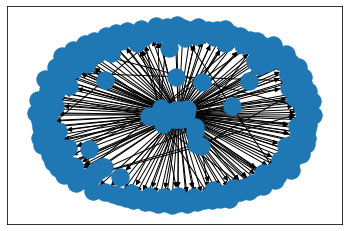

In [9]:
nx.draw_networkx(G, with_labels=False)